# Project_02 : Johnson-Lindenstrauss Lemma

In [7]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim  # minimal number of dimensions(components)

Automatically created module for IPython interactive environment


# Experiment 1 : n_samples vs n_components

Text(0.5, 1.0, 'Johnson-Lindenstrauss bounds:\nn_components vs eps')

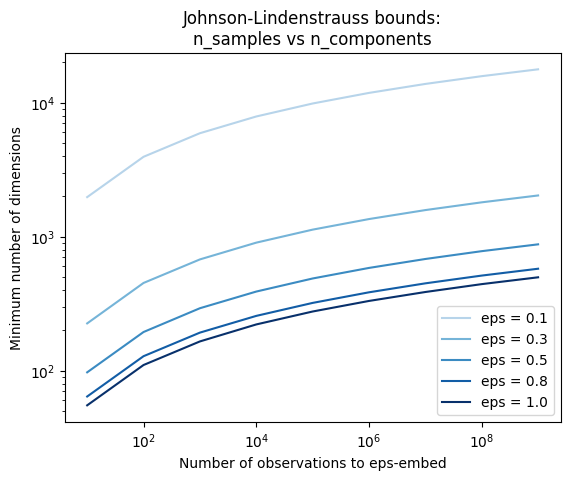

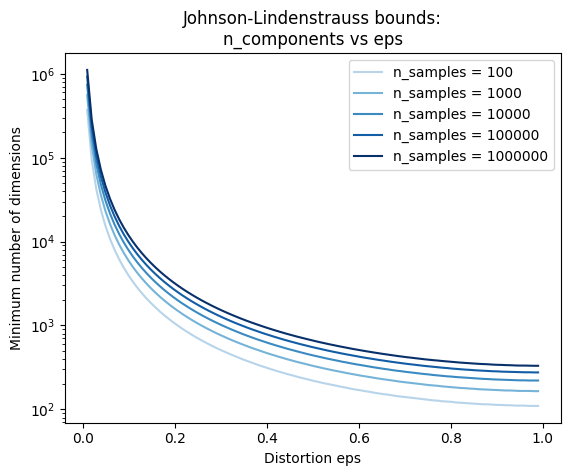

In [9]:

# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = [johnson_lindenstrauss_min_dim(n_samples, eps=eps) for n_samples in n_samples_range] # minimal number of dimensions(components)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")

# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = [johnson_lindenstrauss_min_dim(n_samples, eps=eps) for eps in eps_range] # minimal number of dimensions(components)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend(["n_samples = %d" % n for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")


# Experiment 2 : Gaussian Random Projection

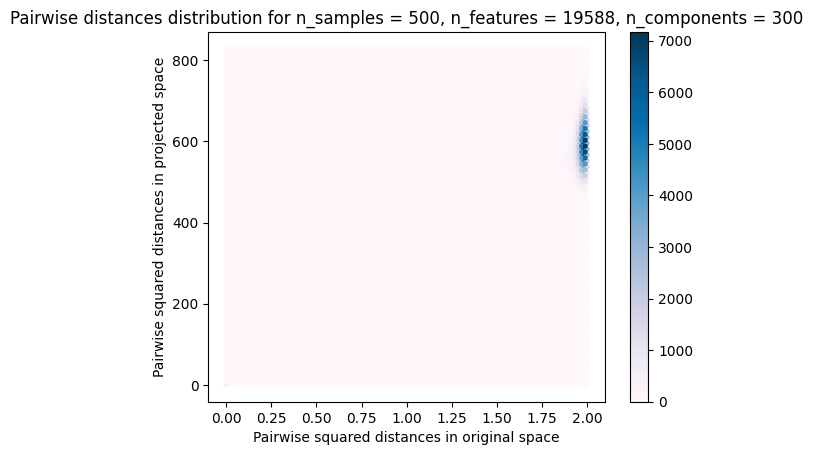

Time taken for pairwise distances in original space: 0.059 seconds
Time taken for pairwise distances in projected space: 0.003 seconds


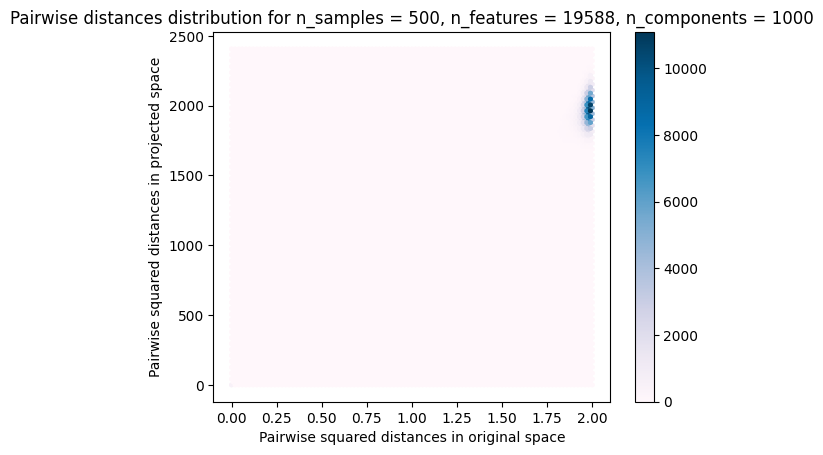

Time taken for pairwise distances in original space: 0.054 seconds
Time taken for pairwise distances in projected space: 0.005 seconds


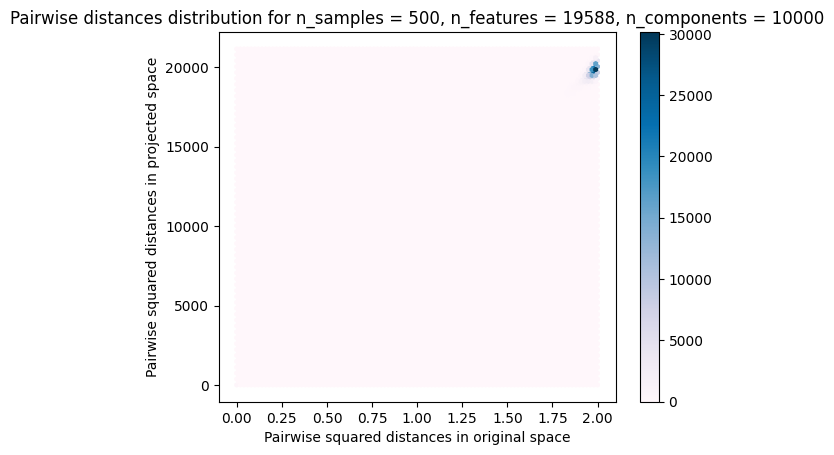

Time taken for pairwise distances in original space: 0.055 seconds
Time taken for pairwise distances in projected space: 0.029 seconds


In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import time

# load dataset
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
data = newsgroups.data
n_samples = 500

# select a subset of the data
if len(data) > n_samples:
    data = data[:n_samples]

# vectorize data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data).toarray()

n_components = [300, 1000, 10000]

for n_comp in n_components:
    # generate Gaussian random projection matrix and apply it to the data
    random_projection = np.random.normal(0, 1, size=(X.shape[1], n_comp))
    X_rp = np.dot(X, random_projection)

    # compute pairwise distances in original space and time it
    start = time.time()
    dists = pairwise_distances(X, squared=True).ravel()
    orig_time = time.time() - start

    # compute pairwise distances in projected space and time it
    start = time.time()
    dists_rp = pairwise_distances(X_rp, squared=True).ravel()
    proj_time = time.time() - start

    # plot pairwise distance distributions
    plt.figure()
    plt.hexbin(dists, dists_rp, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.colorbar()
    plt.title("Pairwise distances distribution for n_samples = %d, n_features = %d, n_components = %d"
              % (X.shape[0], X.shape[1], n_comp))
    plt.show()

    # print out the times taken to compute pairwise distances in each space
    print(f"Time taken for pairwise distances in original space: {orig_time:.3f} seconds")
    print(f"Time taken for pairwise distances in projected space: {proj_time:.3f} seconds")




# Experiment 3 : Sparse Random Projection
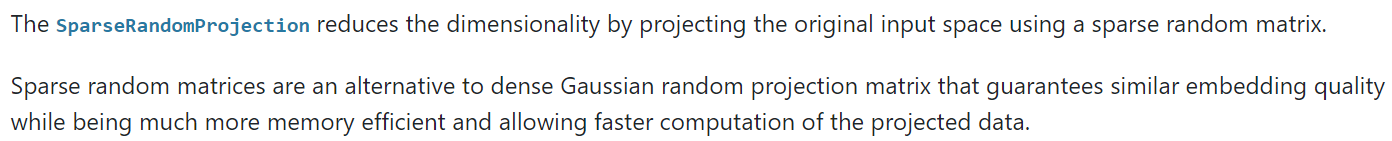

Embedding 500 samples with dim 130107 using various random projections
Projected 500 samples from 130107 to 300 in 0.217s
Mean distances rate: 0.90 (0.17)
Projected 500 samples from 130107 to 1000 in 0.785s
Mean distances rate: 0.97 (0.09)
Projected 500 samples from 130107 to 10000 in 7.214s
Mean distances rate: 1.00 (0.03)


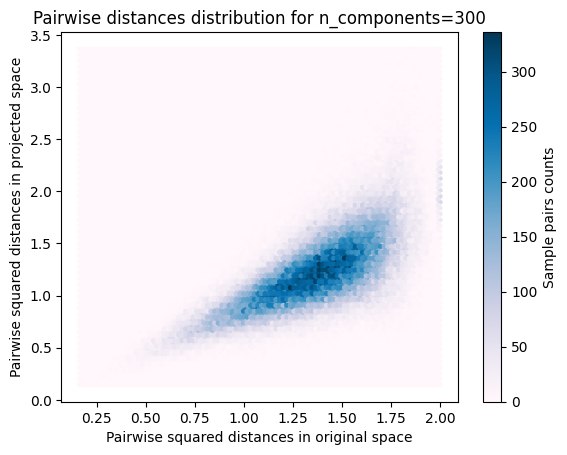

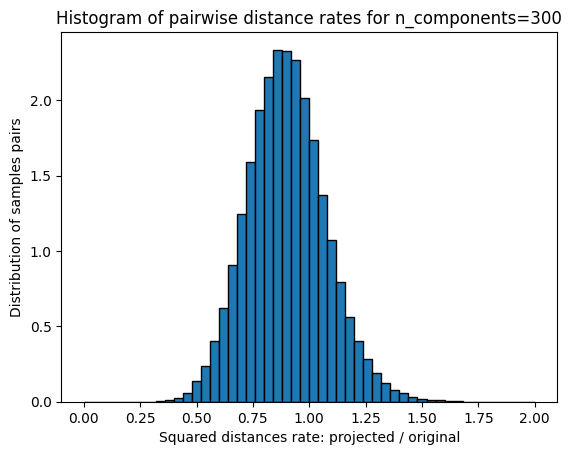

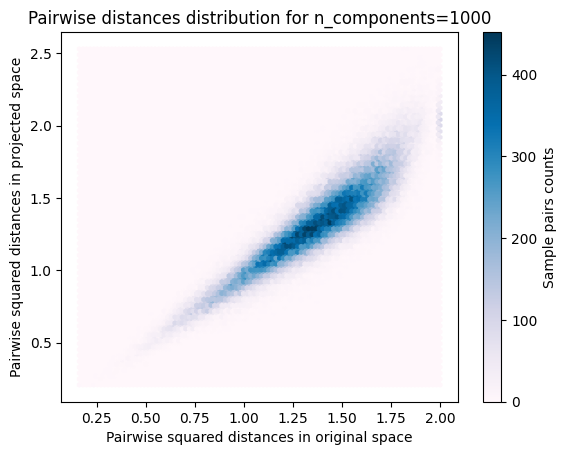

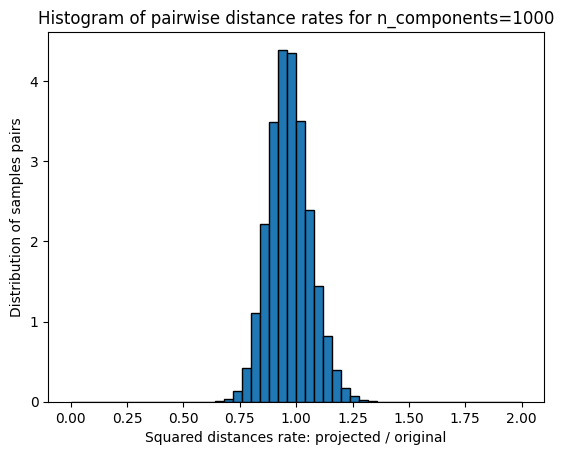

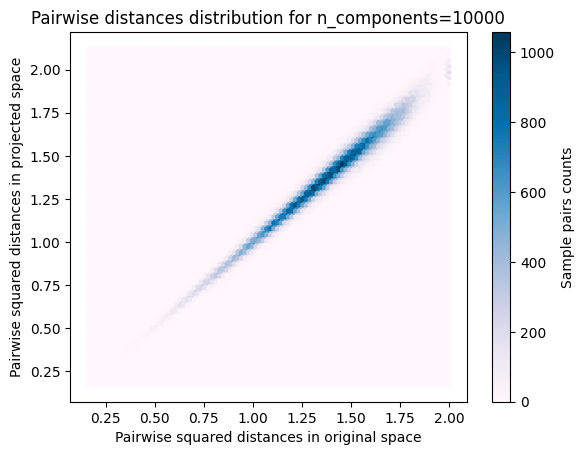

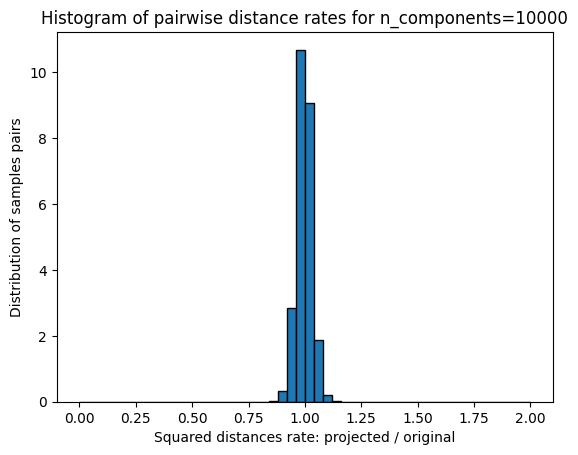

In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import pairwise_distances

# Load data
data = fetch_20newsgroups_vectorized().data[:500]

n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

# Define the range of the number of components
n_components_range = np.array([300, 1000, 10000])

# Compute the pairwise Euclidean distances between all samples in the original high-dimensional space
dists = pairwise_distances(data, squared=True).ravel()

# Select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time.time()
    
    # Reduce dimensionality through Sparse Random Projection
    rp = SparseRandomProjection(n_components=n_components, density='auto', eps=0.1, random_state=42)
    
    # Fit to data, then transform it
    projected_data = rp.fit_transform(data)
    
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time.time() - t0))
    
    # Compute the pairwise Euclidean distances between the projected samples in the low-dimensional space
    projected_dists = pairwise_distances(projected_data, squared=True).ravel()[nonzero]

    # Plot the pairwise distances distribution
    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    # Compute the pairwise distance rates between the original and the projected space
    rates = projected_dists / dists 
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    # Plot the histogram of pairwise distance rates
    plt.figure()
    plt.hist(rates, bins=50, density=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()


